## Notebook imports


In [1]:
from os import walk
from os.path import join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud #https://github.com/amueller/word_cloud/blob/master/examples/simple.py
from PIL import Image #https://pillow.readthedocs.io/en/stable/


from sklearn.model_selection import train_test_split


%matplotlib inline



## Constants

In [119]:
Example_file = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON = 'SpamData/01_Processing/email-text.json'
WORD_ID_FILE = 'SpamData/01_Processing/vocab-word.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/Train.csv'
TEST_DATA_FILE = 'SpamData/02_Training/Test.csv'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files

In [3]:
stream = open(Example_file, encoding= 'latin-1')
message = stream.read()
stream.close()

#type(message)
print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [4]:
import sys

sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(Example_file, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Function


In [6]:
def generate_squares(N): #Example
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [8]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path): #Walk function yields a tuple consisting of directory, directory name and the file name
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):#classification as in spam or not spam email
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):#the file_name and email_body the email_body_generator yields
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})#namng the columns and appending each rows for subsequent files
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
spam_emails.head()
spam_emails.shape

(1898, 2)

In [11]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [12]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,CATEGORY,MESSAGE
00001.7848dde101aa985090474a91ec93fcf0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr..."
00002.d94f1b97e48ed3b553b3508d116e6a09,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00003.2ee33bc6eacdb11f38d052c44819ba6c,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...
00004.eac8de8d759b7e74154f142194282724,1,##############################################...
00005.57696a39d7d84318ce497886896bf90d,1,I thought you might like these:\n\n1) Slim Dow...


In [13]:
data.tail()

,CATEGORY,MESSAGE
01396.61983fbe6ec43f55fd44e30fce24ffa6,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7,0,"> >-- be careful when using this one.) Also, t..."
01398.169b51731fe569f42169ae8f948ec676,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ..."
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co..."
01400.f897f0931e461e7b2e964d28e927c35e,0,"Hi there,\n\n\n\nNow this is probably of no us..."


## Data cleaning- Checking for missing Values

In [14]:
data['MESSAGE'].isnull().values.any()

False

In [15]:
type("")
len("")

0

In [16]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:

data.MESSAGE.isnull().sum()

0

### Locate empty emails


In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

### Remove System files from dataframe

In [21]:
data.drop(['cmds'], inplace = True)

In [22]:
data.shape

(5796, 2)

## Add document IDs to Track emails in Dataset

In [23]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [24]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
0,1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",00001.7848dde101aa985090474a91ec93fcf0
1,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d


In [25]:
data.tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
5791,0,http://news.bbc.co.uk/1/hi/england/2515127.stm...,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,0,"> >-- be careful when using this one.) Also, t...",01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,0,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",01398.169b51731fe569f42169ae8f948ec676
5794,0,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,0,"Hi there,\n\n\n\nNow this is probably of no us...",01400.f897f0931e461e7b2e964d28e927c35e


## Save to File using Pandas

In [26]:
data.to_json(DATA_JSON)

## Number of Emails visualized (Pie Charts)


In [27]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [28]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

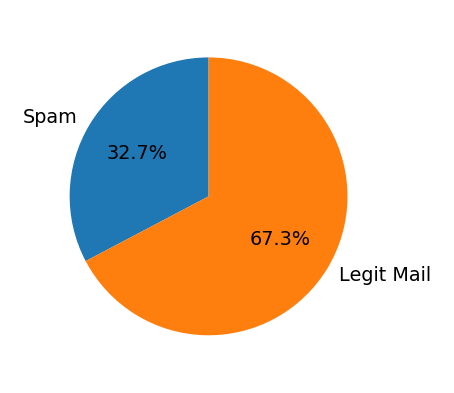

In [29]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.1f%%')
plt.show()

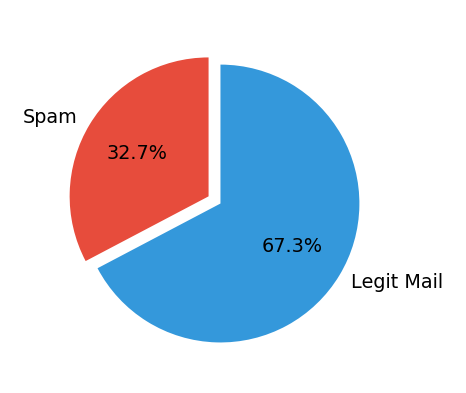

In [30]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
color_palette= ['#e74c3c','#3498db']


plt.figure(figsize=(2, 2), dpi=230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.1f%%', colors = color_palette, explode = [0, 0.1] )
plt.show()

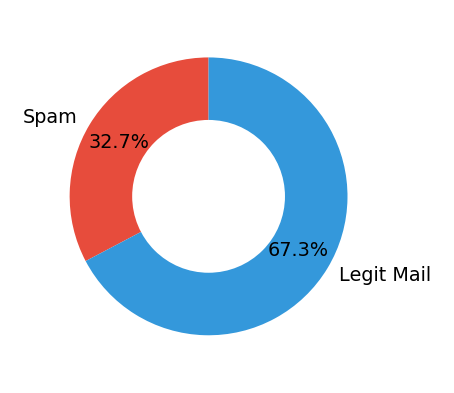

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
color_palette= ['#e74c3c','#3498db']


plt.figure(figsize=(2, 2), dpi=230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.1f%%', colors = color_palette, pctdistance = 0.75 )
#Make a circle
centre_cir = plt.Circle((0,0), radius = 0.55, fc ='white' )
plt.gca().add_artist(centre_cir)

plt.show()

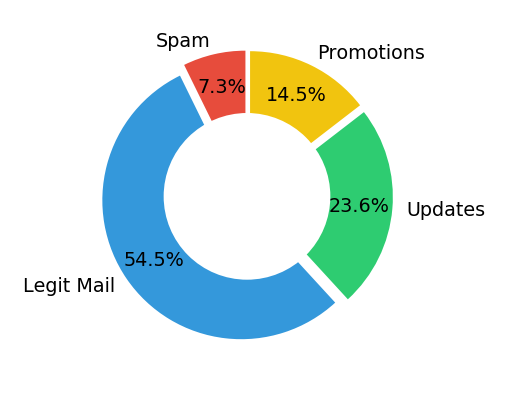

In [32]:
#For practising donut chart with more than 2 categories

category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [20, 150, 65, 40]
color_palette= ['#e74c3c','#3498db', '#2ecc71', '#f1c40f']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=230)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, 
       autopct='%1.1f%%', colors = color_palette, pctdistance = 0.76, explode = offset)
#Make a circle
centre_cir = plt.Circle((0,0), radius = 0.6, fc ='white' )
plt.gca().add_artist(centre_cir)

plt.show()

## Natural Language Processing

### Text pre-processing

In [33]:
msg = 'HELLO everyone'
msg.lower()

'hello everyone'

## Download NLTK Resources (Tokenizer & Stopwords)

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenizing

In [37]:
msg = 'Can you tell me the direction?'
word_tokenize(msg.lower())

['can', 'you', 'tell', 'me', 'the', 'direction', '?']

## Removing Stop words

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
if 'is' in stop_words: print ('Found')

Found


In [40]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


## Word Stems or Stemming

In [41]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.\
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())


#https://www.nltk.org/api/nltk.stem.html
stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit', '!']


## Removing Punctuation

In [42]:
msg = 'All work and no play makes Jack a dull boy. To be, or not to be.\
       Nobody expects the Spanish Inquisition!???'
words = word_tokenize(msg.lower())


#https://www.nltk.org/api/nltk.stem.html
stemmer = PorterStemmer()
#stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags

In [43]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

1) Fight The Risk of Cancer!

http://www.adclick.ws/p.cfm?o=315&amp;s=pk007



2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days

http://www.adclick.ws/p.cfm?o=249&amp;s=pk007



3) Get the Child Support You Deserve - Free Legal Advice

http://www.adclick.ws/p.cfm?o=245&amp;s=pk002



4) Join the Web's Fastest Growing Singles Community

http://www.adclick.ws/p.cfm?o=259&amp;s=pk007



5) Start Your Private Photo Album Online!

http://www.adclick.ws/p.cfm?o=283&amp;s=pk007



Have a Wonderful Day,

Offer Manager

PrizeMama



























If you wish to leave this list please use the link below.

http://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417



In [44]:
soup.get_text()

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

## Functions for Email Processing


In [45]:
def clean_message(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(message.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [46]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [47]:
def clean_msg_no_html(message, stemmer=PorterStemmer(), 
                 stop_words=set(stopwords.words('english'))):
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
#             filtered_words.append(word) 
    
    return filtered_words

In [48]:
clean_msg_no_html(data.at[2, 'MESSAGE'])

['fight',
 'risk',
 'cancer',
 'http',
 'slim',
 'guarante',
 'lose',
 'lb',
 'day',
 'http',
 'get',
 'child',
 'support',
 'deserv',
 'free',
 'legal',
 'advic',
 'http',
 'join',
 'web',
 'fastest',
 'grow',
 'singl',
 'commun',
 'http',
 'start',
 'privat',
 'photo',
 'album',
 'onlin',
 'http',
 'wonder',
 'day',
 'offer',
 'manag',
 'prizemama',
 'wish',
 'leav',
 'list',
 'pleas',
 'use',
 'link',
 'http',
 'zzzz']

## Apply Cleaning and Tokenization to all Messages

### Slicing Dataframes and Series & Creating Subsets 

In [49]:
data.iat[2,2]

'00003.2ee33bc6eacdb11f38d052c44819ba6c'

In [50]:
data.iloc[2:9]

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
2,1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,1,##############################################...,00004.eac8de8d759b7e74154f142194282724
4,1,I thought you might like these:\n\n1) Slim Dow...,00005.57696a39d7d84318ce497886896bf90d
5,1,A POWERHOUSE GIFTING PROGRAM You Don't Want To...,00006.5ab5620d3d7c6c0db76234556a16f6c1
6,1,Help wanted. We are a 14 year old fortune 500...,00007.d8521faf753ff9ee989122f6816f87d7
7,1,<html>\n\n<head>\n\n<title>ReliaQuote - Save U...,00008.dfd941deb10f5eed78b1594b131c9266
8,1,TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...,00009.027bf6e0b0c4ab34db3ce0ea4bf2edab


In [51]:
data.MESSAGE.iloc[0:3]

DOC_ID
0    <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...
1    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
2    1) Fight The Risk of Cancer!\n\nhttp://www.adc...
Name: MESSAGE, dtype: object

In [52]:
first_emails = data.MESSAGE.iloc[0:5796]

nested_list = first_emails.apply(clean_message)

In [53]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)

flat_list = [item for sublist in nested_list for item in sublist]
        
len(flat_list)

928609

In [54]:
%%time

# use apply() on all the messages in the dataframe
nested_list = data.MESSAGE.apply(clean_msg_no_html)

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:335: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


Wall time: 43.8 s


In [55]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, skip, write, jeremi, put...
5794    [mark, hammond, mhammond, like, given, zodb, s...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

### Using Logic to Slice Dataframes

In [56]:
data[data.CATEGORY == 1].tail()

,CATEGORY,MESSAGE,FILE_NAME
DOC_ID,,,
1891,1,"<html>\n\n<head>\n\n<meta http-equiv=""content-...",01396.e80a10644810bc2ae3c1b58c5fd38dfa
1892,1,This is a multi-part message in MIME format.\n...,01397.f75f0dd0dd923faefa3e9cc5ecb8c906
1893,1,"Dear Subscriber,\n\n\n\nIf I could show you a ...",01398.8ca7045aae4184d56e8509dc5ad6d979
1894,1,****Mid-Summer Customer Appreciation SALE!****...,01399.2319643317e2c5193d574e40a71809c2
1895,1,ATTN:SIR/MADAN \n\n\n\n ...,01400.b444b69845db2fa0a4693ca04e6ac5c5


In [57]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [58]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

### Subsetting a Series with an Index

In [59]:
nested_list_ham = nested_list.loc[doc_ids_ham] #doc_ids_ham is an index type while nested_list is a series

In [60]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [61]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()

normal_words.shape[0] # total number of unique words in the non-spam messages

20904

In [62]:
normal_words.head()

http    7959
use     3637
list    2886
one     2377
get     2287
dtype: int64

In [63]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_ham).value_counts()

spammy_words.shape[0] # total number of unique words in the non-spam messages

20904

In [64]:
spammy_words[0:10]

http      7959
use       3637
list      2886
one       2377
get       2287
mail      2259
would     2005
like      1929
messag    1855
work      1798
dtype: int64

## Creating A WordCloud


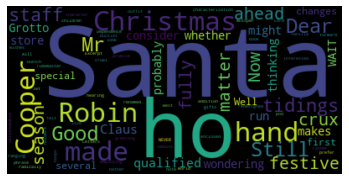

In [65]:
word_cloud = WordCloud().generate(email_body) #the word cloud created from the email_body example
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [66]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')


In [67]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [68]:
example_corpus


['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [69]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

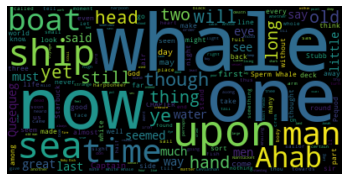

In [70]:
word_cloud = WordCloud().generate(novel_as_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

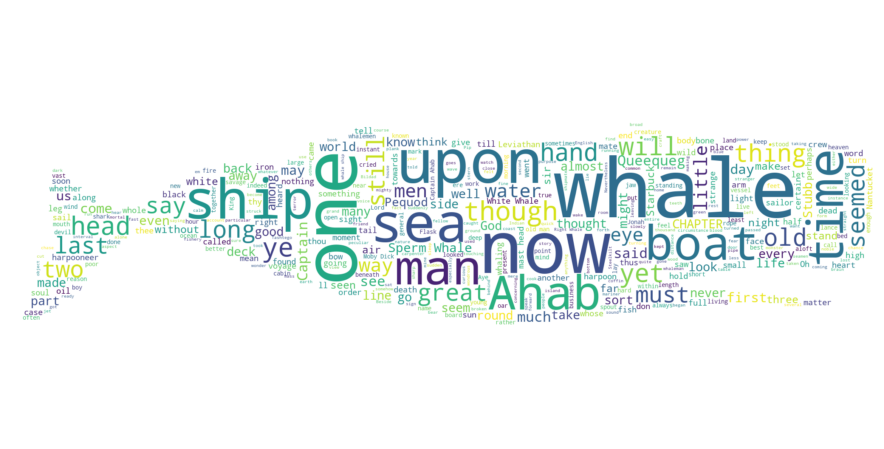

In [71]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='viridis') #https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [72]:
hamlet = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list_2 = [''.join(word) for word in hamlet]
hamlet_novel = ' '.join(word_list_2)

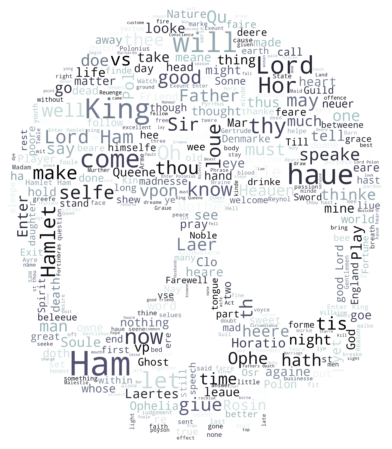

In [73]:
skull_icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size= skull_icon.size, color=(255, 255, 255))
image_mask.paste(skull_icon, box=skull_icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=400, colormap='bone') #https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html

word_cloud.generate(hamlet_novel)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Ham and Spam Messages

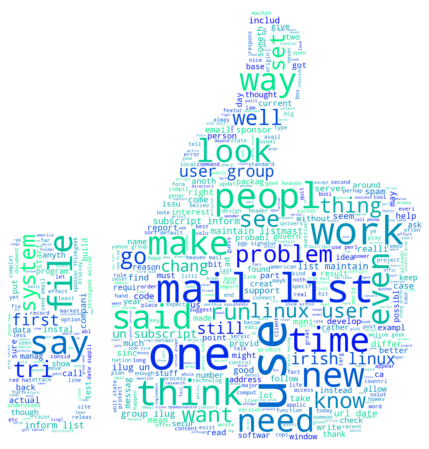

In [74]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

ham_str = ' '.join(flat_list_ham)# Generate the text as a string for the word cloud

word_cloud = WordCloud(mask=rgb_array, background_color='white', 
                      max_words=500, colormap='winter')

word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

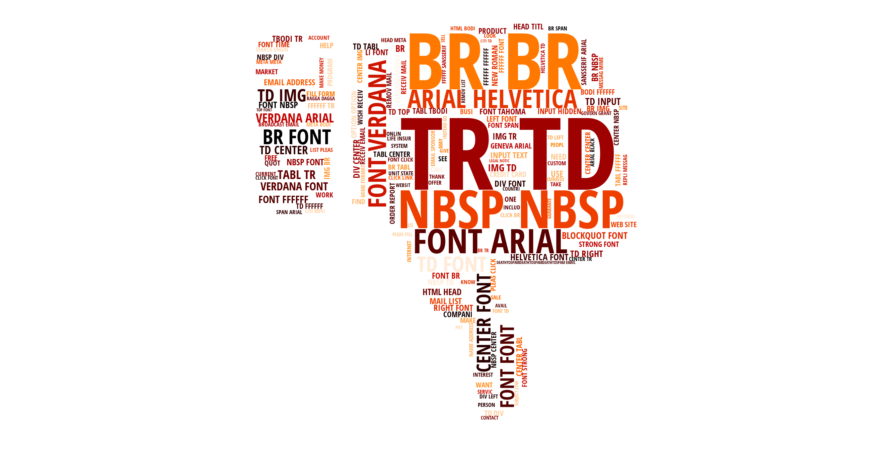

In [75]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,
                      max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE) #google font & font awesome icon

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Generate Vocabulary & Dictionary

In [76]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]#python comprehnsion 

In [77]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27305


http     10662
use       5017
list      4852
email     4370
get       4187
dtype: int64

In [78]:
frequent_words = unique_words[0:VOCAB_SIZE] #creating a subset of unique words
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10662
use       5017
list      4852
email     4370
get       4187
mail      3985
one       3905
free      3171
time      3090
work      2880
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [79]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


## Save the Vocabulary as a CSV File

In [80]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

### Exercise: Checking if a Word is Part of the Vocabulary

In [81]:
# Challenge: Write a line of code that checks if a particular word is part 
# of the vocabulary. Your code should return True if the word is among the 
# 2,500 words that comprise the vocabulary, and False otherwise. Check these words:
# 'machine'
# 'learning'
# 'fun'
# 'learn'
# 'data'
# 'science'
# 'app'
# 'brewery'

any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [82]:
'brew' in set(vocab.VOCAB_WORD) # better way|

False

## Exercise: Find the Email with the Most Number of Words

In [83]:
# Challenge: Print out the number of words in the longest email (after cleaning & stemming).
# Note the longest email's position in the list of cleaned emails. Print out the stemmed
# list of words in the longest email. Print out the longest email from the data dataframe.

# For loop
clean_email_lengths = []
for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [84]:
# Python List Comprehension
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [85]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))


Email position in the list (and the data dataframe) 5775


In [86]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [87]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

## Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [88]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())#stenned_nested_list is converted to list so it can be easily converted to a dataframe
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,save,life,insur,spend,life,quot,save,g,famili,financi,...,None,None,None,None,None,None,None,None,None,None
1,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
2,fight,risk,cancer,http,slim,guarante,lose,lb,day,http,...,None,None,None,None,None,None,None,None,None,None
3,adult,club,offer,free,membership,instant,access,site,user,name,...,None,None,None,None,None,None,None,None,None,None
4,thought,might,like,slim,guarante,lose,lb,day,http,fight,...,None,None,None,None,None,None,None,None,None,None


In [89]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [90]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [91]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [92]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [93]:
y_train.head()


DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [94]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [95]:
word_index.get_loc('use')

1

In [96]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)# The indexed word retrieved from the vocabulary of 2500 words
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [97]:
sparse_train = make_sparse_matrix(X_train, word_index, y_train)

In [98]:
sparse_train[:5]

,DOC_ID,LABEL,OCCURENCE,WORD_ID
0,4844,0,1,266
1,4844,0,1,1259
2,4844,0,1,509
3,4844,0,1,310
4,4844,0,1,255


In [100]:
sparse_train.shape

(430985, 4)

### Combine Occurrences with the Pandas groupby() Method

In [102]:
train_grouped = sparse_train.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [104]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [105]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [106]:
train_grouped = train_grouped.reset_index()


In [107]:
train_grouped.shape

(258379, 4)

### Save Training Data as .txt File

In [120]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

# Challenge

Can you create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [113]:
sparse_test = make_sparse_matrix(X_test, word_index, y_test)

In [114]:
sparse_test.shape

(203148, 4)

In [115]:
test_grouped = sparse_test.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()

In [116]:
test_grouped = test_grouped.reset_index()

In [121]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Subtleties and Checking your Understanding

Challenge: We started with 5796 emails. We split it into 4057 emails for training and 1739 emails for testing. 

How many individual emails were included in the testing .txt file? Count the number in the test_grouped DataFrame. After splitting and shuffling our data, how many emails were included in the X_test DataFrame? Is the number the same? If not, which emails were excluded and why? Compare the DOC_ID values to find out.

In [122]:
train_doc_ids = set(train_grouped.DOC_ID) #For comparison
test_doc_ids = set(test_grouped.DOC_ID)

In [123]:
len(test_doc_ids)

1724

In [126]:
len(X_test)

1739

In [124]:
len(train_doc_ids)

4015

In [125]:
set(X_test.index.values) - test_doc_ids # Excluded emails after pre-processing. The difference shows the missing emails

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [128]:
data.MESSAGE[1700]

'------=_NextPart_000_00A2_25A50A3E.D1003C25\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPEhUTUw+DQo8SEVBRD4NCiAgIA0KICAgPFRJVExFPk1hcnJpZWQgQnV0IExv\n\nbmVseTwvVElUTEU+DQo8L0hFQUQ+DQo8Qk9EWSBCR0NPTE9SPSIjRkZGRkZG\n\nIiBMSU5LPSIjRkYwMDAwIiBWTElOSz0iI0ZGMDAwMCIgQUxJTks9IiNGRjAw\n\nMDAiPg0KDQo8UCBBTElHTj0iY2VudGVyIj4gPElNRyBCT1JERVI9IjAiIFNS\n\nQz0iaHR0cDovL3d3dy5wYWdlNGxpZmUub3JnL3VzZXJzL3h4eGRhdGluZy9t\n\nYXJyaWVkYW5kbG9uZWx5L2ltYWdlcy9sb2dvLmpwZyIgV0lEVEg9IjUwMCIg\n\nSEVJR0hUPSIxOTEiPiZuYnNwOyAmbmJzcDsgPC9QPg0KPENFTlRFUj4NCiAg\n\nPFRBQkxFIENFTExTUEFDSU5HPTUgQ0VMTFBBRERJTkc9NSBCR0NPTE9SPSIj\n\nNjY2Njk5IiA+DQogICAgPFRSPg0KPFREPjxJTUcgU1JDPSJodHRwOi8vd3d3\n\nLnBhZ2U0bGlmZS5vcmcvdXNlcnMveHh4ZGF0aW5nL21hcnJpZWRhbmRsb25l\n\nbHkvcDcwNi5qcGciIEJPUkRFUj0wIEhFSUdIVD0xODAgV0lEVEg9MTIwPjwv\n\nVEQ+DQoNCjxURD48SU1HIFNSQz0iaHR0cDovL3d3dy5wYWdlNGxpZmUub3Jn\n\nL3VzZXJzL3h4eGRhdGluZy9tYXJyaWVkYW5kbG9uZWx5L3A3MDQuanBnIiBC\n\nT1JERVI9MCBIRUlHSFQ9MTgwIF

In [129]:
data.loc[1700]

CATEGORY                                                     1
MESSAGE      ------=_NextPart_000_00A2_25A50A3E.D1003C25\n\...
FILE_NAME               01205.47d139ac094945ae2630efb896dc4b43
Name: 1700, dtype: object

In [132]:
clean_msg_no_html(data.at[298, 'MESSAGE']) 

[]